In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso
import lightgbm as lgb
import xgboost as xgb
import joblib
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from datetime import datetime

# Suppress warnings
warnings.filterwarnings('ignore')

# Create directories for outputs
for directory in ['models', 'results']:
    if not os.path.exists(directory):
        os.makedirs(directory)

print("Current Date and Time:", datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S"))
print("Libraries imported and directories created!")

Current Date and Time: 2025-05-09 15:40:54
Libraries imported and directories created!


#### Dataset Overview and Summary of dataset

In [2]:
# Define file path for the dataset
input_csv_path = r"C:\ML Projects\DS-Intern-Assignment-Faheem-Khan\data\data.csv"


# Load the dataset
def load_data(file_path):
    """Load the dataset and convert data types."""
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    for col in df.select_dtypes(include=['object']).columns:
        if col != 'timestamp':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    print(f"Loaded dataset with shape: {df.shape}")
    return df

# Load dataset
df = load_data(input_csv_path)

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check data types
print("\nData types after conversion:")
print(df.dtypes)

Loaded dataset with shape: (16857, 29)

First 5 rows of the dataset:
            timestamp  equipment_energy_consumption  lighting_energy  \
0 2016-01-11 17:00:00                          60.0       -77.787786   
1 2016-01-11 17:10:00                          60.0        30.000000   
2 2016-01-11 17:20:00                          50.0        30.000000   
3 2016-01-11 17:30:00                          50.0        40.000000   
4 2016-01-11 17:40:00                          60.0        40.000000   

   zone1_temperature  zone1_humidity  zone2_temperature  zone2_humidity  \
0          33.746609       47.596667               19.2       44.790000   
1          19.890000       46.693333               19.2       44.722500   
2          19.890000       46.300000               19.2       44.626667   
3          33.746609       46.066667               19.2       44.590000   
4          19.890000       46.333333               19.2       44.530000   

   zone3_temperature  zone3_humidity  zone4_tem


Basic statistics:
                           timestamp  equipment_energy_consumption  \
count                          16857                  15945.000000   
mean   2016-03-10 02:16:38.647446272                     95.810413   
min              2016-01-11 17:00:00                  -1139.985693   
25%              2016-02-09 21:20:00                     50.000000   
50%              2016-03-10 00:10:00                     60.000000   
75%              2016-04-08 03:40:00                    100.000000   
max              2016-12-01 15:50:00                   1139.985693   
std                              NaN                    182.753554   

       lighting_energy  zone1_temperature  zone1_humidity  zone2_temperature  \
count     15993.000000       15908.000000    15969.000000       15934.000000   
mean          3.938101          21.249414       39.046066          19.793113   
min         -86.002966           8.726818      -46.660000           2.988199   
25%           0.000000        

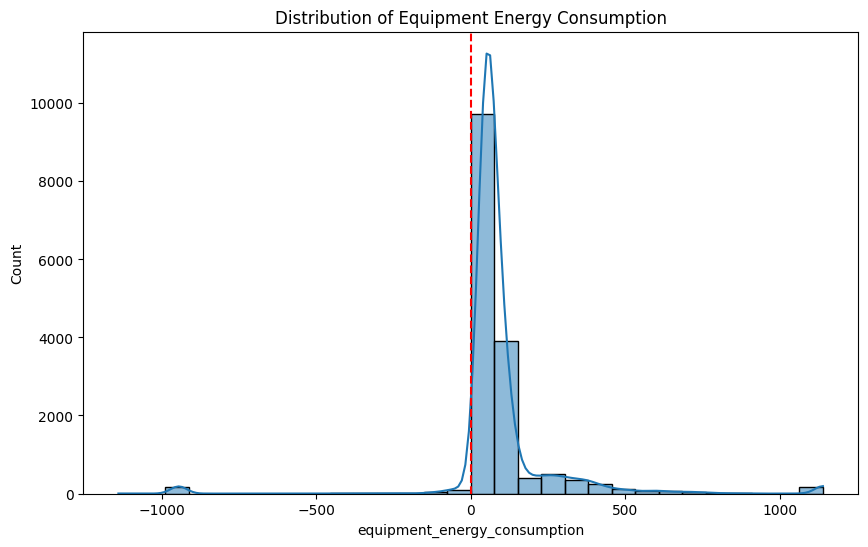

In [3]:
# Basic statistics of the dataset
print("\nBasic statistics:")
print(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
print(f"Total missing values: {missing_values.sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Analyze the target variable
def analyze_target_variable(df):
    """Analyze the target variable distribution."""
    target = 'equipment_energy_consumption'
    
    print("\n=== Target Variable Analysis ===")
    print(f"Unique values in {target}: {df[target].nunique()}")
    print(f"Min: {df[target].min()}, Max: {df[target].max()}")
    print("Most common values:")
    print(df[target].value_counts().head(10))
    
    # Check for negative values
    negative_count = (df[target] < 0).sum()
    print(f"\nNegative energy consumption values: {negative_count} ({negative_count/len(df)*100:.2f}% of data)")
    
    # Plot histogram of target variable
    plt.figure(figsize=(10, 6))
    sns.histplot(df[target], bins=30, kde=True)
    plt.title('Distribution of Equipment Energy Consumption')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.savefig('results/target_distribution.png')
    plt.show()

# Run target analysis
analyze_target_variable(df)